In [4]:
# Required Libraries
import folium
import folium.plugins
import pandas as pd
import random
import numpy as np
import copy
import os
import time as tm

from itertools import cycle
from matplotlib import pyplot as plt
plt.style.use('bmh')
fleet_used = [0,0,0,0,0]
############################################################################
# Function: Tour Plot
def plot_tour_coordinates (coordinates, solution, n_depots, route, size_x = 10, size_y = 10):
    depot     = solution[0]
    city_tour = solution[1]  # [[3,2,6,2],[15,2,7,6]]
    cycol     = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#bf77f6', '#ff9408', 
                       '#d1ffbd', '#c85a53', '#3a18b1', '#ff796c', '#04d8b2', '#ffb07c', '#aaa662', '#0485d1', '#fffe7a', '#b0dd16', '#d85679', '#12e193', 
                       '#82cafc', '#ac9362', '#f8481c', '#c292a1', '#c0fa8b', '#ca7b80', '#f4d054', '#fbdd7e', '#ffff7e', '#cd7584', '#f9bc08', '#c7c10c'])
    plt.figure(figsize = [size_x, size_y])
    for j in range(0, len(city_tour)):
        if (route == 'closed'):
            xy = np.zeros((len(city_tour[j]) + 2, 2))
        else:
            xy = np.zeros((len(city_tour[j]) + 1, 2))
        for i in range(0, xy.shape[0]):
            if (i == 0):
                xy[ i, 0] = coordinates[depot[j][i], 0]
                xy[ i, 1] = coordinates[depot[j][i], 1]
                if (route == 'closed'):
                    xy[-1, 0] = coordinates[depot[j][i], 0]
                    xy[-1, 1] = coordinates[depot[j][i], 1]
            if (i > 0 and i < len(city_tour[j])+1):
                xy[i, 0] = coordinates[city_tour[j][i-1], 0]
                xy[i, 1] = coordinates[city_tour[j][i-1], 1]
        plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 0.5, markersize = 5, color = next(cycol))
    for i in range(0, coordinates.shape[0]):
        if (i < n_depots):
            plt.plot(coordinates[i,0], coordinates[i,1], marker = 's', alpha = 1.0, markersize = 7, color = 'k')[0]
            plt.text(coordinates[i,0], coordinates[i,1], i, ha = 'center', va = 'bottom', color = 'k', fontsize = 7)
        else:
            plt.text(coordinates[i,0],  coordinates[i,1], i, ha = 'center', va = 'bottom', color = 'k', fontsize = 7)
    plt.savefig('line_visualization.png')
    return

# Function: Tour Plot - Lat Long
def plot_tour_latlong (lat_long, solution, n_depots, route):
    m       = folium.Map(location = (lat_long.iloc[0][0], lat_long.iloc[0][1]), zoom_start = 14)
    clients = folium.plugins.MarkerCluster(name = 'Clients').add_to(m)
    depots  = folium.plugins.MarkerCluster(name = 'Depots').add_to(m)
    for i in range(0, lat_long.shape[0]):
        if (i < n_depots):
            folium.Marker(location = [lat_long.iloc[i][0], lat_long.iloc[i][1]], popup = '<b>Client: </b>%s</br> <b>Adress: </b>%s</br>'%(int(i), 'D'), icon = folium.Icon(color = 'black', icon = 'home')).add_to(depots)
        else:
            folium.Marker(location = [lat_long.iloc[i][0], lat_long.iloc[i][1]], popup = '<b>Client: </b>%s</br> <b>Adress: </b>%s</br>'%(int(i), 'C'), icon = folium.Icon(color = 'blue')).add_to(clients)
    depot     = solution[0]
    city_tour = solution[1]
    cycol     = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#bf77f6', '#ff9408', 
                       '#d1ffbd', '#c85a53', '#3a18b1', '#ff796c', '#04d8b2', '#ffb07c', '#aaa662', '#0485d1', '#fffe7a', '#b0dd16', '#d85679', '#12e193', 
                       '#82cafc', '#ac9362', '#f8481c', '#c292a1', '#c0fa8b', '#ca7b80', '#f4d054', '#fbdd7e', '#ffff7e', '#cd7584', '#f9bc08', '#c7c10c'])
    for j in range(0, len(city_tour)):
        if (route == 'closed'):
            ltlng = np.zeros((len(city_tour[j]) + 2, 2))
        else:
            ltlng = np.zeros((len(city_tour[j]) + 1, 2))
        for i in range(0, ltlng.shape[0]):
            if (i == 0):
                ltlng[ i, 0] = lat_long.iloc[depot[j][i], 0]
                ltlng[ i, 1] = lat_long.iloc[depot[j][i], 1]
                if (route == 'closed'):
                    ltlng[-1, 0] = lat_long.iloc[depot[j][i], 0]
                    ltlng[-1, 1] = lat_long.iloc[depot[j][i], 1]
            if (i > 0 and i < len(city_tour[j])+1):
                ltlng[i, 0] = lat_long.iloc[city_tour[j][i-1], 0]
                ltlng[i, 1] = lat_long.iloc[city_tour[j][i-1], 1]
        c = next(cycol)
        for i in range(0, ltlng.shape[0]-1):
          locations = [ (ltlng[i,0], ltlng[i,1]), (ltlng[i+1,0], ltlng[i+1,1])]
          folium.PolyLine(locations , color = c, weight = 1.5, opacity = 1).add_to(m)
    return m

# Function: Subroute Distance
def evaluate_distance(distance_matrix, depot, subroute):    
    subroute_i    = depot + subroute
    subroute_j    = subroute + depot
    subroute_ij   = [(subroute_i[i], subroute_j[i]) for i in range(0, len(subroute_i))]
    distance      = list(np.cumsum(distance_matrix[tuple(np.array(subroute_ij).T)]))
    distance[0:0] = [0.0]
    return distance

# Function: Subroute Time
def evaluate_time(distance_matrix, parameters, depot, subroute, velocity):  
    tw_early   = parameters[:, 1]
    tw_late    = parameters[:, 2]
    tw_st      = parameters[:, 3]
    subroute_i = depot + subroute
    subroute_j = subroute + depot
    wait       = [0]*len(subroute_j)
    time       = [0]*len(subroute_j)
    for i in range(0, len(time)):
        time[i] = time[i] + distance_matrix[(subroute_i[i], subroute_j[i])]/velocity[0]

        if (time[i] < tw_early[subroute_j][i][0]):
            wait[i] = tw_early[subroute_j][i][0] - time[i]
            time[i] = tw_early[subroute_j][i][0]
            day_num = 0
        elif (time[i] < tw_late[subroute_j][i][0]):
            wait[i] = 0
            day_num = 0          
        elif (time[i] < tw_early[subroute_j][i][1]):
            wait[i] = tw_early[subroute_j][i][1] - time[i]
            time[i] = tw_early[subroute_j][i][1]  
            day_num = 1
        elif (time[i] < tw_late[subroute_j][i][1]):
            wait[i] = 0
            day_num = 1
        elif (time[i] < tw_early[subroute_j][i][2]):
            wait[i] = tw_early[subroute_j][i][2] - time[i]
            time[i] = tw_early[subroute_j][i][2]  
            day_num = 2
        elif (time[i] < tw_late[subroute_j][i][2]):
            wait[i] = 0
            day_num = 2
        else:
            day_num = 2  
        time[i] = time[i] + tw_st[subroute_j][i]
                
        if (i + 1 <= len(time) - 1):
            time[i+1] = time[i]

    time[0:0] = [0]
    wait[0:0] = [0]
    return wait, time, day_num

# Function: Subroute Capacity
def evaluate_capacity(parameters, depot, subroute): 
    demand    = parameters[:, 5]
    subroute_ = depot + subroute + depot
    capacity  = list(np.cumsum(demand[subroute_]))
    return capacity 

# Function: Subroute Cost
def evaluate_cost(dist, wait, parameters, depot, subroute, fixed_cost, variable_cost, time_window):
    tw_wc     = parameters[:, 4]
    subroute_ = depot + subroute + depot
    cost      = [0]*len(subroute_)
    if (time_window == 'with'):
        cost = [fixed_cost[0] + y*z if x == 0 else fixed_cost[0] + x*variable_cost[0] + y*z for x, y, z in zip(dist, wait, tw_wc[subroute_])]
    else:
        cost = [fixed_cost[0]  if x == 0 else fixed_cost[0] + x*variable_cost[0]  for x in dist]
    return cost

# Function: Subroute Cost
def evaluate_cost_penalty(dist, time, wait, cap, capacity, parameters, depot, subroute, fixed_cost, variable_cost, penalty_value, time_window, route, day_num):
    tw_late = parameters[:, 2]
    tw_st   = parameters[:, 3]
    tw_wc   = parameters[:, 4]
    if (route == 'open'):
        subroute_ = depot + subroute
    else:
        subroute_ = depot + subroute + depot
    pnlt = 0
    cost = [0]*len(subroute_)
    pnlt = pnlt + sum( x > capacity for x in cap[0:len(subroute_)] )
    if(time_window == 'with'):
        pnlt = pnlt + sum(x > y + z for x, y, z in zip(time, tw_late[subroute_][day_num] , tw_st[subroute_]))  
        cost = [fixed_cost[0] + y*z if x == 0 else cost[0] + x*variable_cost[0] + y*z for x, y, z in zip(dist, wait, tw_wc[subroute_])]
    else:
        cost = [fixed_cost[0] if x == 0 else cost[0] + x*variable_cost[0] for x in dist]        
    cost[-1] = cost[-1] + pnlt*penalty_value
    return cost[-1]

# Function: Routes Nearest Depot
def evaluate_depot(n_depots, individual, real_distance_matrix):
    d_1 = float('+inf')
    for i in range(0, n_depots):
        for j in range(0, len(individual[1])):
            d_2 = evaluate_distance(real_distance_matrix, [i], individual[1][j])[-1]
            if (d_2 < d_1):
                d_1 = d_2
                individual[0][j] = [i]
    return individual

# Function: Routes Best Vehicle
def evaluate_vehicle(vehicle_types, individual, distance_matrix, parameters, velocity, fixed_cost, variable_cost, capacity, penalty_value, time_window, route,real_distance_matrix, fleet_size, fleet_used=fleet_used):
    cost, _     = target_function([individual], distance_matrix, parameters, velocity, fixed_cost, variable_cost, capacity, penalty_value, time_window, route,real_distance_matrix, fleet_size, fleet_used = fleet_used) 
    individual_ = copy.deepcopy(individual)
    for i in range(0, len(individual[0])):
        for j in range(0, vehicle_types):
            individual_[2][i] = [j]
            cost_, _             = target_function([individual_], distance_matrix, parameters, velocity, fixed_cost, variable_cost, capacity, penalty_value, time_window, route, real_distance_matrix, fleet_size, fleet_used=fleet_used) 
            if (cost_ < cost):
                cost             = cost_
                individual[2][i] = [j]     
                individual_      = copy.deepcopy(individual)
            else:
                individual_      = copy.deepcopy(individual)
    return individual

# Function: Routes Break Capacity
def cap_break(vehicle_types, individual, parameters, capacity):
    go_on = True
    while (go_on):
        individual_ = copy.deepcopy(individual)
        solution    = [[], [], []]
        for i in range(0, len(individual_[0])):
            cap   = evaluate_capacity(parameters, individual_[0][i], individual_[1][i]) 
            sep   = [x >  capacity[individual_[2][i][0]] for x in cap[1:-1] ]
            sep_f = [individual_[1][i][x] for x in range(0, len(individual_[1][i])) if sep[x] == False]
            sep_t = [individual_[1][i][x] for x in range(0, len(individual_[1][i])) if sep[x] == True ]
            if (len(sep_t) > 0 and len(sep_f) > 0):
                solution[0].append(individual_[0][i])
                solution[0].append(individual_[0][i])
                solution[1].append(sep_f)
                solution[1].append(sep_t)
                solution[2].append(individual_[2][i])
                solution[2].append(individual_[2][i])
            if (len(sep_t) > 0 and len(sep_f) == 0):
                solution[0].append(individual_[0][i])
                solution[1].append(sep_t)
                solution[2].append(individual_[2][i])
            if (len(sep_t) == 0 and len(sep_f) > 0):
                solution[0].append(individual_[0][i])
                solution[1].append(sep_f)
                solution[2].append(individual_[2][i])
        individual_ = copy.deepcopy(solution)
        if (individual == individual_):
            go_on      = False
        else:
            go_on      = True
            individual = copy.deepcopy(solution)
    return individual

# Function: Solution Report
def show_report(solution, distance_matrix,  parameters, velocity, fixed_cost, variable_cost, route, time_window,real_distance_matrix, fleet_used=fleet_used):
    column_names = ['Route', 'Vehicle', 'Activity', 'Job_도착지점의 index', 'Arrive_Load', 'Leave_Load', 'Wait_Time', 'Arrive_Time','Leave_Time', 'Distance', 'Costs']
    tt           = 0
    td           = 0 
    tc           = 0
    tw_st        = parameters[:, 3]
    report_lst   = []
    no_fixed_cost_count = [0,0,0,0,0]
    
    for i in range(0, len(solution[1])):
        dist         = evaluate_distance(real_distance_matrix, solution[0][i], solution[1][i])
        wait, time   = evaluate_time(distance_matrix, parameters, solution[0][i], solution[1][i], velocity = [velocity[solution[2][i][0]]])[0:2]
        reversed_sol = copy.deepcopy(solution[1][i])
        reversed_sol.reverse()
        cap          = evaluate_capacity(parameters, solution[0][i], reversed_sol) 
        cap.reverse()
        leave_cap = copy.deepcopy(cap)
        for n in range(1, len(leave_cap)-1):
            leave_cap[n] = cap[n+1] 

        flag = True
        if fleet_used[solution[2][i][0]] > no_fixed_cost_count[solution[2][i][0]]:
            flag = False
            no_fixed_cost_count[solution[2][i][0]] += 1

        if flag:
            cost = evaluate_cost(dist, wait, parameters, solution[0][i], solution[1][i], fixed_cost = [fixed_cost[solution[2][i][0]]], variable_cost = [variable_cost[solution[2][i][0]]], time_window = time_window)
        else:
            cost = evaluate_cost(dist, wait, parameters, solution[0][i], solution[1][i], fixed_cost = [0],                               variable_cost = [variable_cost[solution[2][i][0]]], time_window = time_window)

        if (route == 'closed'):
            subroute = [solution[0][i] + solution[1][i] + solution[0][i] ]
        elif (route == 'open'):
            subroute = [solution[0][i] + solution[1][i] ]
        for j in range(0, len(subroute[0])):
            if (j == 0):
                activity    = 'start'
                arrive_time = round(time[j],2)
            else:
                arrive_time = round(time[j] - tw_st[subroute[0][j]] - wait[j],2)
            if (j > 0 and j < len(subroute[0]) - 1):
                activity = 'service'  
            if (j == len(subroute[0]) - 1):
                activity = 'finish'
                if (time[j] > tt):
                    tt = time[j]
                td = td + dist[j]
                tc = tc + cost[j]
            report_lst.append(['#' + str(i+1), solution[2][i][0], activity, subroute[0][j], cap[j], leave_cap[j], round(wait[j],2), arrive_time, round(time[j],2), round(dist[j],2), round(cost[j],2) ])
        report_lst.append(['-//-', '-//-', '-//-', '-//-','-//-', '-//-', '-//-', '-//-', '-//-', '-//-', '-//-'])
    report_lst.append(['MAX TIME', '', '','', '', '', '', '', round(tt,2), '', ''])
    report_lst.append(['TOTAL', '', '','', '', '', '', '', '', round(td,2), round(tc,2)])
    report_df = pd.DataFrame(report_lst, columns = column_names)
    return report_df

# Function: Route Evalution & Correction
# 각 population의 cost만 계산
def target_function(population, distance_matrix, parameters, velocity, fixed_cost, variable_cost, capacity, penalty_value, time_window, route, real_distance_matrix, fleet_size = [], fleet_used=fleet_used):
    cost     = [[0] for i in range(len(population))]
    tw_late  = parameters[:, 2]
    tw_st    = parameters[:, 3]
    flt_cnt  = [0]*len(fleet_size)
    if (route == 'open'):
        end = 2 
    else:
        end = 1

    no_fixed_cost_count = [0,0,0,0,0]
    # k individuals, individual은 각 차들의 route
    # individual[i] = [depot(출발), route(list type), vehicle]
    # 거리*비용 + penalty
    for k in range(0, len(population)): # k individuals
        individual = copy.deepcopy(population[k])  
        size       = len(individual[1])
        i          = 0
        pnlt       = 0
        flt_cnt    = [0]*len(fleet_size)
        while (size > i): # i subroutes 
            dist = evaluate_distance(real_distance_matrix, individual[0][i], individual[1][i])
            if(time_window == 'with'):
                wait, time, day_num = evaluate_time(distance_matrix, parameters, depot = individual[0][i], subroute = individual[1][i], velocity = [velocity[individual[2][i][0]]])
            else:
                wait       = []
                time       = []
            cap    = evaluate_capacity(parameters, depot = individual[0][i], subroute = individual[1][i])
                  
            pnlt   = pnlt + sum( x >  capacity[individual[2][i][0]] for x in cap[0:-1] )
            if(time_window == 'with'):
                if (route == 'open'):
                    subroute_ = individual[0][i] + individual[1][i]
                else:
                    subroute_ = individual[0][i] + individual[1][i] + individual[0][i]
                pnlt = pnlt + sum(x > y + z for x, y, z in zip(time, tw_late[subroute_][day_num] , tw_st[subroute_]))                      
            if (len(fleet_size) > 0):
                flt_cnt[individual[2][i][0]] = flt_cnt[individual[2][i][0]] + 1 
            if (size <= i + 1):
                for v in range(0, len(fleet_size)):
                    v_sum = flt_cnt[v] - fleet_size[v]
                    if (v_sum > 0):
                        pnlt = pnlt + v_sum #차량 대수 조절

            flag = True
            if fleet_used[individual[2][i][0]] > no_fixed_cost_count[individual[2][i][0]]:
                flag = False
                no_fixed_cost_count[individual[2][i][0]] += 1

            if flag:
                cost_s = evaluate_cost(dist, wait, parameters, depot = individual[0][i], subroute = individual[1][i], fixed_cost = [fixed_cost[individual[2][i][0]]], variable_cost = [variable_cost[individual[2][i][0]]], time_window = time_window)
            else:
                cost_s = evaluate_cost(dist, wait, parameters, depot = individual[0][i], subroute = individual[1][i], fixed_cost = [0],                                 variable_cost = [variable_cost[individual[2][i][0]]], time_window = time_window)

            cost[k][0] = cost[k][0] + cost_s[-end] + pnlt*penalty_value

            size       = len(individual[1])
            i          = i + 1

    cost_total = copy.deepcopy(cost)
    return cost_total, population

# Function: Initial Population
# CBM만 넘지 않게 일단일단 차량 배정
def initial_population(parameters, coordinates='none', distance_matrix='none', population_size=5, vehicle_types=1, n_depots=1, model='vrp', capacity = [20,30,40,40,50]):

    # Exclude clients with demand equal to 0
    # 1, 2, 3, ..., 한 터미널의 날짜의 그룹의 주문의 개수
    non_zero_demand_clients = [i for i in range(1, len(parameters[:,0]))] #[client for client in range(n_depots, distance_matrix.shape[0]) if coordinates[client][0] != 0]
    depots = [[i] for i in range(n_depots)]
    vehicles = [[i] for i in range(vehicle_types)]
    population = []

    for i in range(population_size):
        clients_temp = copy.deepcopy(non_zero_demand_clients)  # Use the filtered clients with non-zero demand
        
        #route는 출발지, route_depot: 도착지
        routes = []
        routes_depot = []
        routes_vehicles = []

        while len(clients_temp) > 0:
            e = random.sample(vehicles, 1)[0]
            d = random.sample(depots, 1)[0]
            c = random.sample(clients_temp, random.randint(1, len(clients_temp)))
            # 차량 적재량 넘으면 다시 돌리기
            if sum([parameters[:, 5][int(i)] for i in c]) > capacity[int(e[0])]:
                continue

            tmp = []
            # 차량 배정
            for idx in c:                
                tmp.append(int(parameters[:,0][int(idx)]))
            
            routes_vehicles.append(e)
            routes_depot.append(d)
            routes.append(tmp)
            clients_temp = [item for item in clients_temp if item not in c]

        population.append([routes_depot, routes, routes_vehicles])

    return population

# Function: Fitness
def fitness_function(cost, population_size): 
    fitness = np.zeros((population_size, 2))
    for i in range(0, fitness.shape[0]):
        fitness[i,0] = 1/(1 + cost[i][0] + abs(np.min(cost)))
    fit_sum      = fitness[:,0].sum()
    fitness[0,1] = fitness[0,0]
    for i in range(1, fitness.shape[0]):
        fitness[i,1] = (fitness[i,0] + fitness[i-1,1])
    for i in range(0, fitness.shape[0]):
        fitness[i,1] = fitness[i,1]/fit_sum
    return fitness

# Function: Selection
def roulette_wheel(fitness): 
    ix     = 0
    random = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
    for i in range(0, fitness.shape[0]):
        if (random <= fitness[i, 1]):
          ix = i
          break
    return ix

# Function: VRP Crossover - BRBAX (Best Route Better Adjustment Recombination)
def crossover_vrp_brbax(parent_1, parent_2):
    s         = random.sample(list(range(0,len(parent_1[0]))), 1)[0]
    subroute  = [ parent_1[0][s], parent_1[1][s], parent_1[2][s] ]
    offspring = copy.deepcopy(parent_2)
    for k in range(len(parent_2[1])-1, -1, -1):
        offspring[1][k] = [item for item in offspring[1][k] if item not in subroute[1] ] 
        if (len(offspring[1][k]) == 0):
            del offspring[0][k]
            del offspring[1][k]
            del offspring[2][k]
    offspring[0].append(subroute[0])
    offspring[1].append(subroute[1])
    offspring[2].append(subroute[2])
    return offspring

# Function: VRP Crossover - BCR (Best Cost Route Crossover)
def crossover_vrp_bcr(parent_1, parent_2, distance_matrix, velocity, capacity, fixed_cost, variable_cost, penalty_value, time_window, parameters, route, real_distance_matrix):
    s         = random.sample(list(range(0,len(parent_1[0]))), 1)[0]
    offspring = copy.deepcopy(parent_2)
    if (len(parent_1[1][s]) > 1):
        cut  = random.sample(list(range(0,len(parent_1[1][s]))), 2)
        gene = 2
    else:
        cut  = [0, 0]
        gene = 1
    for i in range(0, gene):
        d_1   = float('+inf')
        ins_m = 0
        A     = parent_1[1][s][cut[i]]
        best  = []
        for m in range(0, len(parent_2[1])):
            parent_2[1][m] = [item for item in parent_2[1][m] if item not in [A] ]
            if (len(parent_2[1][m]) > 0):
                insertion      = copy.deepcopy([ parent_2[0][m], parent_2[1][m], parent_2[2][m] ])
                dist_list      = [evaluate_distance(real_distance_matrix, insertion[0], insertion[1][:n] + [A] + insertion[1][n:]) for n in range(0, len(parent_2[1][m]) + 1)]
                if(time_window == 'with'):
                    wait_time_list = [evaluate_time(distance_matrix, parameters, insertion[0], insertion[1][:n] + [A] + insertion[1][n:], velocity = [velocity[parent_2[2][m][0]] ] ) for n in range(0, len(parent_2[1][m]) + 1)]
                else:
                    wait_time_list = [[0, 0]]*len(dist_list)
                day_num_list   = [evaluate_time(distance_matrix, parameters, insertion[0], insertion[1][:n] + [A] + insertion[1][n:], velocity = [velocity[parent_2[2][m][0]] ] )[2] for n in range(0, len(parent_2[1][m]) + 1)]
                cap_list       = [evaluate_capacity(parameters, insertion[0], insertion[1][:n] + [A] + insertion[1][n:]) for n in range(0, len(parent_2[1][m]) + 1)]
                insertion_list = [insertion[1][:n] + [A] + insertion[1][n:] for n in range(0, len(parent_2[1][m]) + 1)]
                d_2_list       = [evaluate_cost_penalty(dist_list[n], wait_time_list[n][1], wait_time_list[n][0], cap_list[n], capacity[parent_2[2][m][0]], parameters, insertion[0], insertion_list[n], [fixed_cost[parent_2[2][m][0]]], [variable_cost[parent_2[2][m][0]]], penalty_value, time_window, route, day_num_list[n]) for n in range(0, len(dist_list))]
                d_2 = min(d_2_list)
                if (d_2 <= d_1):
                    d_1   = d_2
                    ins_m = m
                    best  = insertion_list[d_2_list.index(min(d_2_list))]
        parent_2[1][ins_m] = best            
        if (d_1 != float('+inf')):
            offspring = copy.deepcopy(parent_2)
    for i in range(len(offspring[1])-1, -1, -1):
        if(len(offspring[1][i]) == 0):
            del offspring[0][i]
            del offspring[1][i]
            del offspring[2][i]
    return offspring

# breeding function이 제약조건을 만족하는지 check, 제약 조건은 initial population과 동일
def check_individual_capacity(individual, parameters, capacity):
    for route_num in range(len(individual[1])):
        if sum([parameters[:, 5][int(i)] for i in individual[1][route_num]]) > capacity[int(individual[2][route_num][0])]:
            return False
    return True

# Function: Breeding
def breeding(cost, population, fitness, distance_matrix, n_depots, elite, velocity, capacity, fixed_cost, variable_cost, penalty_value, time_window, parameters, route, vehicle_types, fleet_size,real_distance_matrix, fleet_used):
    offspring = copy.deepcopy(population) 

    if (elite > 0):
        cost, population = (list(t) for t in zip(*sorted(zip(cost, population))))
        for i in range(0, elite):
            offspring[i] = copy.deepcopy(population[i])

    for i in range (elite, len(offspring)):
        flag = True
        # 좋은 조건의 부모 둘 뽑아서, 섞음(어떻게 섞는지는 일단 out of mind)
        while flag:
            parent_1, parent_2 = roulette_wheel(fitness), roulette_wheel(fitness)
            while parent_1 == parent_2:
                parent_2 = random.sample(range(0, len(population) - 1), 1)[0]
            parent_1 = copy.deepcopy(population[parent_1])  
            parent_2 = copy.deepcopy(population[parent_2])
            rand = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)  

            if((len(parent_1[1]) > 1 and len(parent_2[1]) > 1)):
                if (rand > 0.5):
                    offspring[i] = crossover_vrp_brbax(parent_1, parent_2)
                    offspring[i] = crossover_vrp_bcr(offspring[i], parent_2, distance_matrix, velocity, capacity, fixed_cost, variable_cost, penalty_value, time_window = time_window, parameters = parameters, route = route, real_distance_matrix=real_distance_matrix)              
                elif (rand <= 0.5): 
                    offspring[i] = crossover_vrp_brbax(parent_2, parent_1)
                    offspring[i] = crossover_vrp_bcr(offspring[i], parent_1, distance_matrix, velocity, capacity, fixed_cost, variable_cost, penalty_value, time_window = time_window, parameters = parameters, route = route, real_distance_matrix=real_distance_matrix)
            if (n_depots > 1):
                offspring[i] = evaluate_depot(n_depots, offspring[i], distance_matrix) 
            if (vehicle_types > 1):
                offspring[i] = evaluate_vehicle(vehicle_types, offspring[i], distance_matrix, parameters, velocity, fixed_cost, variable_cost, capacity, penalty_value, time_window, route,real_distance_matrix, fleet_size, fleet_used=fleet_used)
        
            offspring[i] = cap_break(vehicle_types, offspring[i], parameters, capacity)
    
            if check_individual_capacity(offspring[i], parameters, capacity):
                flag = False

    return offspring

# Function: Mutation - Swap
def mutation_tsp_vrp_swap(individual):
    if (len(individual[1]) == 1):
        k1 = random.sample(list(range(0, len(individual[1]))), 1)[0]
        k2 = k1
    else:
        k  = random.sample(list(range(0, len(individual[1]))), 2)
        k1 = k[0]
        k2 = k[1]  
    cut1                    = random.sample(list(range(0, len(individual[1][k1]))), 1)[0]
    cut2                    = random.sample(list(range(0, len(individual[1][k2]))), 1)[0]
    A                       = individual[1][k1][cut1]
    B                       = individual[1][k2][cut2]
    individual[1][k1][cut1] = B
    individual[1][k2][cut2] = A
    return individual

# Function: Mutation - Insertion
def mutation_tsp_vrp_insertion(individual):
    if (len(individual[1]) == 1):
        k1 = random.sample(list(range(0, len(individual[1]))), 1)[0]
        k2 = k1
    else:
        k  = random.sample(list(range(0, len(individual[1]))), 2)
        k1 = k[0]
        k2 = k[1]
    cut1 = random.sample(list(range(0, len(individual[1][k1])))  , 1)[0]
    cut2 = random.sample(list(range(0, len(individual[1][k2])+1)), 1)[0]
    A    = individual[1][k1][cut1]
    del individual[1][k1][cut1]
    individual[1][k2][cut2:cut2] = [A]
    if (len(individual[1][k1]) == 0):
        del individual[0][k1]
        del individual[1][k1]
        del individual[2][k1]
    return individual

# Function: Mutation
def mutation(offspring, mutation_rate, elite):
    for i in range(elite, len(offspring)):
        probability = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
        if (probability <= mutation_rate):
            rand = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
            if (rand <= 0.5):
                offspring[i] = mutation_tsp_vrp_insertion(offspring[i])
            elif(rand > 0.5):
                offspring[i] = mutation_tsp_vrp_swap(offspring[i])
        for k in range(0, len(offspring[i][1])):
            if (len(offspring[i][1][k]) >= 2):
                probability = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
                if (probability <= mutation_rate):
                    rand = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
                    cut  = random.sample(list(range(0, len(offspring[i][1][k]))), 2)
                    cut.sort()
                    C    = offspring[i][1][k][cut[0]:cut[1]+1]
                    if (rand <= 0.5):
                        random.shuffle(C)
                    elif(rand > 0.5):
                        C.reverse()
                    offspring[i][1][k][cut[0]:cut[1]+1] = C
    return offspring

# Function: Elite Distance
def elite_distance(individual, distance_matrix, route):
    if (route == 'open'):
        end = 2
    else:
        end = 1
    td = 0
    for n in range(0, len(individual[1])):
        td = td + evaluate_distance(distance_matrix, depot = individual[0][n], subroute = individual[1][n])[-end]
    return round(td,2)

# GA-VRP Function
def genetic_algorithm_vrp(coordinates, distance_matrix, parameters, velocity, fixed_cost, variable_cost, capacity, real_distance_matrix, population_size = 5, vehicle_types = 1, n_depots = 1, route = 'closed', model = 'vrp', time_window = 'without', fleet_size = [], mutation_rate = 0.1, elite = 0, generations = 50, penalty_value = 1000, graph = True, selection = 'rw', fleet_used = fleet_used):    
    start           = tm.time()
    count           = 0
    solution_report = ['None']
    max_capacity    = copy.deepcopy(capacity)
    population       = initial_population(parameters, coordinates, distance_matrix, population_size = population_size, vehicle_types = vehicle_types, n_depots = n_depots, model = model, capacity = capacity)   
    cost, population = target_function(population, distance_matrix, parameters, velocity, fixed_cost, variable_cost, max_capacity, penalty_value, time_window = time_window, route = route, fleet_size = fleet_size, real_distance_matrix=real_distance_matrix,fleet_used=fleet_used) 
    cost, population = (list(t) for t in zip(*sorted(zip(cost, population))))
    # 기존 코드, finess_function을 통해 각 경우의 population에 점수 배정
    if (selection == 'rw'):
        fitness          = fitness_function(cost, population_size)
    elif (selection == 'rb'):
        rank             = [[i] for i in range(1, len(cost)+1)]
        fitness          = fitness_function(rank, population_size)
    elite_ind        = elite_distance(population[0], distance_matrix, route = route)
    cost             = copy.deepcopy(cost)
    elite_cst        = copy.deepcopy(cost[0][0])
    solution         = copy.deepcopy(population[0])
    print('Generation = ', count, ' Distance = ', elite_ind, ' f(x) = ', round(elite_cst, 2)) 
    while (count <= generations-1): 
        offspring        = breeding(cost, population, fitness, distance_matrix, n_depots, elite, velocity, max_capacity, fixed_cost, variable_cost, penalty_value, time_window, parameters, route, vehicle_types, fleet_size,real_distance_matrix, fleet_used=fleet_used)          
        offspring        = mutation(offspring, mutation_rate = mutation_rate, elite = elite)
        cost, population = target_function(offspring, distance_matrix, parameters, velocity, fixed_cost, variable_cost, max_capacity, penalty_value, time_window = time_window, route = route, fleet_size = fleet_size,real_distance_matrix=real_distance_matrix, fleet_used=fleet_used)
        cost, population = (list(t) for t in zip(*sorted(zip(cost, population))))
        elite_child      = elite_distance(population[0], distance_matrix, route = route)    #elite는 그대로
        if (selection == 'rw'):
            fitness = fitness_function(cost, population_size)
        elif (selection == 'rb'):
            rank    = [[i] for i in range(1, len(cost)+1)]
            fitness = fitness_function(rank, population_size)
        if(elite_ind > elite_child):    #cost가 제일 낮은 한 개는 각 iter마다 일단 뽑아둠
            elite_ind = elite_child 
            solution  = copy.deepcopy(population[0])
            elite_cst = copy.deepcopy(cost[0][0])
        count = count + 1  
        print('Generation = ', count, ' Distance = ', elite_ind, ' f(x) = ', round(elite_cst, 2))
    if (graph == True):
        plot_tour_coordinates(coordinates, solution, n_depots = n_depots, route = route)

    fleet_used_now = [0] * 5
    # 주어진 리스트에서 각 값이 몇 번 나왔는지 카운트
    for sublist in solution[2]:
        value = sublist[0]
        fleet_used_now[value] += 1

    solution_report = show_report(solution, distance_matrix, parameters, velocity, fixed_cost, variable_cost, route = route, time_window  = time_window,real_distance_matrix=real_distance_matrix, fleet_used=fleet_used)
    end = tm.time()

    print('Algorithm Time: ', round((end - start), 2), ' seconds')
    return solution_report, solution, fleet_used_now
   
   ############################################################################

In [5]:
import pandas as pd
import random
import numpy as np
import copy
import os
import time as tm
import numpy as np
from itertools import cycle
from matplotlib import pyplot as plt

od_df = pd.read_csv('./과제3 실시간 주문 대응 Routing 최적화 (od_matrix) 수정완료.csv')

pivot_table = pd.read_csv("./pivot_table_filled.csv", encoding='cp949', index_col=[0])

real_distance_matrix = pd.read_csv("./distance_matrix.csv", index_col=0)

demand_df = pd.read_csv('./과제3 실시간 주문 대응 Routing 최적화 (orders_table) 수정완료.csv', encoding='cp949')
# for i in range(1, 6):
#     for j in range(4):
tmp_df = demand_df[demand_df['date']=='2023-05-02']
tmp_df = tmp_df[tmp_df['Group'].isin([0])]
tmp_df = tmp_df[tmp_df['터미널ID']=='O_179']

id_list_only_in_tmp_df = list(set(tmp_df['터미널ID'].values.tolist() + tmp_df['착지ID'].values.tolist()))
pivot_table = pivot_table.loc[id_list_only_in_tmp_df,id_list_only_in_tmp_df]
pivot_table = pivot_table.sort_index(axis=1, ascending=False)
pivot_table = pivot_table.sort_index(axis=0,  ascending=False)

# '착지_ID'열의 각 값의 인덱스를 담을 리스트 초기화
index_positions = [list(pivot_table.index).index("O_179")]
cbm_list = [0]

# tmp_df의 '착지_ID'열의 각 값에 대해 pivot_table.index 리스트의 인덱스를 찾습니다.
for i in range(len(tmp_df)):
    value = tmp_df['착지ID'].values.tolist()[i]
    index_positions.append(list(pivot_table.index).index(value))
    cbm_list.append(float(tmp_df['CBM'].values[i]))

departure_coordinates = demand_df.drop_duplicates(['착지ID'])[['착지ID', '하차지_위도', '하차지_경도']]
departure_coordinates.columns = ['ID', 'y', 'x']
origin_coordinates = pd.read_csv("./과제3 실시간 주문 대응 Routing 최적화 (Terminals).csv", encoding='cp949', usecols = [0,1,2])
origin_coordinates.columns = departure_coordinates.columns
coordinates = pd.concat([departure_coordinates, origin_coordinates], ignore_index=True)
coordinates = coordinates.set_index(['ID'])
coordinates = coordinates.reindex(index=pivot_table.index)
coordinates = coordinates.loc[id_list_only_in_tmp_df].sort_index(ascending=False).reset_index(drop=True)

# 시간을 분 단위로 변환하는 함수
def time_to_minutes(time_str):
    hour, minute = map(int, time_str.split(':'))
    return hour * 60 + minute

# 3일간의 하차 가능 시작과 끝 시간 리스트를 구하는 함수
# 여기서 이미 time_window와 무관하게 3일차(4320분)에 딱 cut하도록 만들어 놓음
def get_trip_time_lists(start_time, end_time, num_days=3):
    start_time_minutes = time_to_minutes(start_time)
    end_time_minutes = time_to_minutes(end_time)
    
    start_list = []
    end_list = []
    
    for day in range(num_days):
        if start_time_minutes + day * 24 * 60 > 4320:
            start_list.append(4320)
        else:
            start_list.append((start_time_minutes + day * 24 * 60) )
        
        if start_time_minutes > end_time_minutes:
            if end_time_minutes + (day+1) * 24 * 60 > 4320:
                end_list.append(4320)
            else:
                end_list.append((end_time_minutes + (day+1) * 24 * 60))
        else:
            if end_time_minutes + day * 24 * 60 > 4320:
                end_list.append(4320)
            else:
                end_list.append((end_time_minutes + day * 24 * 60) )
        
    return start_list, end_list

# 3일간의 하차 가능 시작과 끝 시간 리스트 계산
trip_start_times = [[0,0,0]]
trip_end_times = [[4320,4320,4320]]

for idx, row in tmp_df.iterrows():
    start_time = row['하차가능시간_시작']
    end_time = row['하차가능시간_종료']
    start_list, end_list = get_trip_time_lists(start_time, end_time)
    trip_start_times.append(start_list)
    trip_end_times.append(end_list)

parameters = pd.DataFrame({
    'arrive_station': index_positions,
    'TW_early':trip_start_times,
    'TW_late':trip_end_times,
    'TW_service_time':60,
    'TW_wait_cost':0,
    'cbm':cbm_list
})

# Tranform to Numpy Array
coordinates = coordinates.values
parameters  = parameters.values
distance_matrix = pivot_table.values
real_distance_matrix = real_distance_matrix.values

# Parameters - Model
n_depots    =  1          # The First n Rows of the 'distance_matrix' or 'coordinates' are Considered as Depots
time_window = 'with'    # 'with', 'without'
route       = 'closed'     # 'open', 'closed'
model       = 'vrp'        # 'tsp', 'mtsp', 'vrp'
graph       = True        # True, False

# Parameters - Vehicle
vehicle_types = 5                           # Quantity of Vehicle Types
fixed_cost    = [ 80,110,150,200,250 ]      # Fixed Cost
variable_cost = [ 0.8,1,1.2,1.5,1.8 ]      # Variable Cost
capacity      = [ 27,33,42,51,55 ]      # Capacity of the Vehicle
velocity      = [ 1,1,1,1,1 ]      # The Average Velocity Value is Used as a Constant that Divides the Distance Matrix.
fleet_size    = [ 10,10,10,10,10 ]      # Available Vehicles

# Parameters - GA
penalty_value   = 1000000    # GA Target Function Penalty Value for Violating the Problem Constraints
population_size = 10      # GA Population Size
mutation_rate   = 0.2     # GA Mutation Rate
elite           = 1        # GA Elite Member(s) - Total Number of Best Individual(s) that (is)are Maintained 
generations     = 100     # GA Number of Generations

fleet_used = [0,0,0,0,0]
# Run GA Function
ga_report, ga_vrp, fleet_used_now = genetic_algorithm_vrp(coordinates, distance_matrix, parameters, velocity, fixed_cost, variable_cost, capacity, real_distance_matrix, population_size, vehicle_types, n_depots, route, model, time_window, fleet_size, mutation_rate, elite, generations, penalty_value, graph, 'rw', fleet_used)

Generation =  0  Distance =  5990.9  f(x) =  7008332.05
Generation =  1  Distance =  5652.37  f(x) =  5224.64
Generation =  2  Distance =  4934.31  f(x) =  4150.37
Generation =  3  Distance =  4520.73  f(x) =  3961.45
Generation =  4  Distance =  4520.73  f(x) =  3961.45
Generation =  5  Distance =  4498.46  f(x) =  3618.15
Generation =  6  Distance =  4498.46  f(x) =  3618.15
Generation =  7  Distance =  4371.81  f(x) =  3376.99
Generation =  8  Distance =  4371.81  f(x) =  3376.99
Generation =  9  Distance =  4371.81  f(x) =  3376.99
Generation =  10  Distance =  4371.81  f(x) =  3376.99
Generation =  11  Distance =  4292.95  f(x) =  3356.7
Generation =  12  Distance =  4292.95  f(x) =  3356.7
Generation =  13  Distance =  4292.95  f(x) =  3356.7
Generation =  14  Distance =  4292.95  f(x) =  3356.7
Generation =  15  Distance =  4292.95  f(x) =  3356.7
Generation =  16  Distance =  4292.95  f(x) =  3356.7
Generation =  17  Distance =  3907.77  f(x) =  3140.45
Generation =  18  Distan

KeyboardInterrupt: 

In [66]:
# Solution Report
ga_report

,Route,Vehicle,Activity,Job_도착지점의 index,Arrive_Load,Leave_Load,Wait_Time,Arrive_Time,Leave_Time,Distance,Costs
0,#1,0,start,0,22.749973,22.749973,0,0,0,0.0,80
1,#1,0,service,12,22.749973,9.061889,1060.87,19.13,1140,37.86,110.29
2,#1,0,service,20,9.061889,0.0,638.17,1221.83,1920,86.95,149.56
3,#1,0,finish,0,0.0,0.0,0,1992.4,2052.4,142.95,194.36
4,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-
...,...,...,...,...,...,...,...,...,...,...,...
58,#13,2,service,17,34.695964,0.0,0,1331.76,1391.76,55.74,216.89
59,#13,2,finish,0,0.0,0.0,0,1544.55,1604.55,103.47,274.17
60,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-
61,MAX TIME,,,,,,,,2532.71,,


In [67]:
fleet_used_now

[5, 3, 3, 2, 0]

In [96]:
# Solution Report - Save
#ga_report.to_csv('VRP-02-Report.csv', encoding= 'cp949', index = False)

Generation =  0  Distance =  6274.0  f(x) =  68008403.23
Generation =  1  Distance =  5480.1  f(x) =  5275.7
Generation =  2  Distance =  5480.1  f(x) =  5275.7
Generation =  3  Distance =  5480.1  f(x) =  5275.7
Generation =  4  Distance =  5480.1  f(x) =  5275.7
Generation =  5  Distance =  5480.1  f(x) =  5275.7
Generation =  6  Distance =  5480.1  f(x) =  5275.7
Generation =  7  Distance =  5480.1  f(x) =  5275.7
Generation =  8  Distance =  5480.1  f(x) =  5275.7
Generation =  9  Distance =  5480.1  f(x) =  5275.7
Generation =  10  Distance =  5480.1  f(x) =  5275.7
Generation =  11  Distance =  5480.1  f(x) =  5275.7
Generation =  12  Distance =  5480.1  f(x) =  5275.7
Generation =  13  Distance =  5480.1  f(x) =  5275.7
Generation =  14  Distance =  5480.1  f(x) =  5275.7
Generation =  15  Distance =  5480.1  f(x) =  5275.7
Generation =  16  Distance =  5480.1  f(x) =  5275.7
Generation =  17  Distance =  5480.1  f(x) =  5275.7
Generation =  18  Distance =  5480.1  f(x) =  5275.

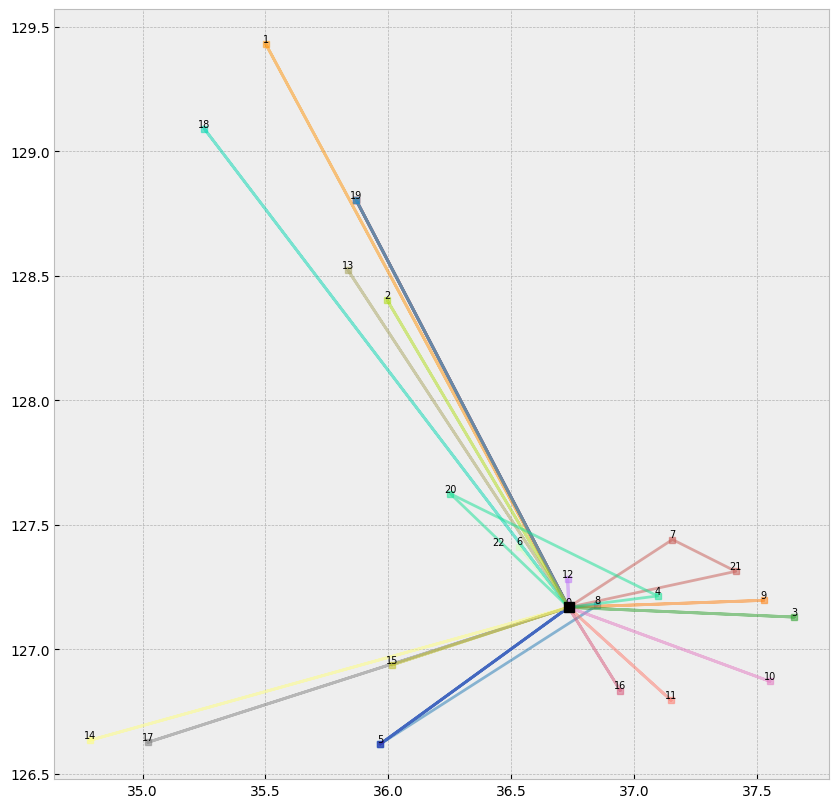

In [69]:
pivot_table = pd.read_csv("./pivot_table_filled.csv", encoding='cp949', index_col=[0])

demand_df = pd.read_csv('./과제3 실시간 주문 대응 Routing 최적화 (orders_table) 수정완료.csv', encoding='cp949')
tmp_df = demand_df[demand_df['date']=='2023-05-02']
tmp_df = tmp_df[tmp_df['Group'].isin([1])]
tmp_df = tmp_df[tmp_df['터미널ID']=='O_179']

id_list_only_in_tmp_df = list(set(tmp_df['터미널ID'].values.tolist() + tmp_df['착지ID'].values.tolist()))
pivot_table = pivot_table.loc[id_list_only_in_tmp_df,id_list_only_in_tmp_df]
pivot_table = pivot_table.sort_index(axis=1, ascending=False)
pivot_table = pivot_table.sort_index(axis=0,  ascending=False)

# '착지_ID'열의 각 값의 인덱스를 담을 리스트 초기화
index_positions = [list(pivot_table.index).index("O_179")]
cbm_list = [0]

# tmp_df의 '착지_ID'열의 각 값에 대해 pivot_table.index 리스트의 인덱스를 찾습니다.
for i in range(len(tmp_df)):
    value = tmp_df['착지ID'].values.tolist()[i]
    index_positions.append(list(pivot_table.index).index(value))
    cbm_list.append(float(tmp_df['CBM'].values[i]))

# 3일간의 하차 가능 시작과 끝 시간 리스트 계산
trip_start_times = [[0,0,0]]
trip_end_times = [[4320,4320,4320]]

for idx, row in tmp_df.iterrows():
    start_time = row['하차가능시간_시작']
    end_time = row['하차가능시간_종료']
    start_list, end_list = get_trip_time_lists(start_time, end_time)
    trip_start_times.append(start_list)
    trip_end_times.append(end_list)

parameters = pd.DataFrame({
    'arrive_station': index_positions,
    'TW_early':trip_start_times,
    'TW_late':trip_end_times,
    'TW_service_time':60,
    'TW_wait_cost':0,
    'cbm':cbm_list
})

parameters  = parameters.values

# Parameters - Model
n_depots    =  1          # The First n Rows of the 'distance_matrix' or 'coordinates' are Considered as Depots
time_window = 'with'    # 'with', 'without'
route       = 'closed'     # 'open', 'closed'
model       = 'vrp'        # 'tsp', 'mtsp', 'vrp'
graph       = True        # True, False

##################################
#이전 그룹에서 6시간 이후에 도착하는 차량만큼 fleet size에서 빼야됨
##################################

# Parameters - Vehicle
vehicle_types = 5                           # Quantity of Vehicle Types
fixed_cost    = [ 80,110,150,200,250 ]      # Fixed Cost
variable_cost = [ 0.8,1,1.2,1.5,1.8 ]      # Variable Cost
capacity      = [ 27,33,42,51,55 ]      # Capacity of the Vehicle
velocity      = [ 1,1,1,1,1 ]      # The Average Velocity Value is Used as a Constant that Divides the Distance Matrix.
fleet_size    = [ 10,10,10,10,10 ]      # Available Vehicles

# Parameters - GA
penalty_value   = 1000000    # GA Target Function Penalty Value for Violating the Problem Constraints
population_size = 10      # GA Population Size
mutation_rate   = 0.2     # GA Mutation Rate
elite           = 1        # GA Elite Member(s) - Total Number of Best Individual(s) that (is)are Maintained 
generations     = 100     # GA Number of Generations

import copy
fleet_used = copy.deepcopy(fleet_used_now)

# Run GA Function
ga_report, ga_vrp, fleet_used_now = genetic_algorithm_vrp(coordinates, distance_matrix, parameters, velocity, fixed_cost, variable_cost, capacity, real_distance_matrix, population_size, vehicle_types, n_depots, route, model, time_window, fleet_size, mutation_rate, elite, generations, penalty_value, graph, 'rw', fleet_used)

In [70]:
ga_report

,Route,Vehicle,Activity,Job_도착지점의 index,Arrive_Load,Leave_Load,Wait_Time,Arrive_Time,Leave_Time,Distance,Costs
0,#1,4,start,0,52.595785,52.595785,0,0,0,0.0,0
1,#1,4,service,8,52.595785,27.967368,401.97,18.03,480,34.8,62.63
2,#1,4,service,5,27.967368,0.0,498.6,581.4,1140,41.6,74.87
3,#1,4,finish,0,0.0,0.0,0,1230.43,1290.43,69.66,125.38
4,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-
...,...,...,...,...,...,...,...,...,...,...,...
96,#24,2,service,20,30.208334,0.0,0,1244.13,1304.13,85.85,253.02
97,#24,2,finish,0,0.0,0.0,0,1376.54,1436.54,141.84,320.21
98,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-,-//-
99,MAX TIME,,,,,,,,1436.54,,


In [71]:
fleet_used_now

[7, 6, 6, 3, 2]